# Boost-Factor Models

Here I try to mimic Y1 boost factor to apply for the buzzard datavector

In [1]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

In [2]:
from astropy.cosmology import FlatLambdaCDM
cosmo0 = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
cosmo0 

FlatLambdaCDM(H0=70.0 km / (Mpc s), Om0=0.3, Tcmb0=2.725 K, Neff=3.04, m_nu=[0. 0. 0.] eV, Ob0=None)

## Halo Catalog

Before applying a redMaPPer selection we use the true dark matter buzzard mock halo catalog. 

In [3]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.halo_run_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/buzzard-1.9.8_3y3a_run_halos_lambda_chisq_mu_star.fit


This file contains all buzzard halos with $ M_{200} >10^{12}M_{\odot}$. This catalog also has redMaPPer outputs and $\mu_{\star, \rm true}$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

# Effective $\Sigma_{\rm c}$ 

The crital density is for a given object. For instance, when a galaxy is observed on an Einstein ring the critical density of that observation is the redshift of the source galaxy. In the weak lensing regime, we have several sources. Our sources depends of how many galaxies we select, i.e. the galaxies by a given survey.

If we had a complete catalog the sources would be all the galaxies behind the cluster. And the redshift distribution would increase monotonichally.

In [10]:
from scipy.interpolate import interp1d
zbins = np.linspace(0.05, 0.94, 21)
zmean = 0.5*(zbins[:-1] + zbins[1:])
# pdfz, _ = np.histogram(redshift_pdz, bins=zbins, density=True)

In [11]:
pzsel = np.load('pdfz_mock_buzzrd_y3like.npz')
# pz interp
pz_interp = interp1d(pzsel['z'], pzsel['pdfz'], fill_value='extrapolate')

Text(0.5, 0, 'z')

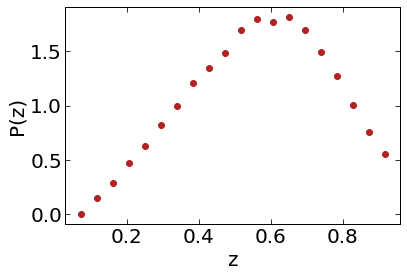

In [12]:
plt.scatter(zmean, pz_interp(zmean), color='firebrick', label='All Sources')
plt.ylabel('P(z)')
plt.xlabel('z')

In [13]:
def completeness_formula(m, A=0.94, m50=24.88, rho=0.65):
    """ Completeness functional form
    See eq 7 from Martin et al. 2016
    """
    # modidfication for redshift
    rho*= (1+m)
    denominator = 1+np.exp((m-m50)/rho)
    res = A/denominator
    return res

# based on the completeness formula I'll do something to redshift
# des redshift limit
zlim = 0.8
# redshift window size of redshift falling
z_window_length = 0.05
sel_function = completeness_formula(zsources, m50= zlim, rho=z_window_length)

NameError: name 'zsources' is not defined

In [ ]:
# help(interp1d)

In [14]:
plt.plot(zsources, pz, 'k--', label='Extrapolation')
plt.plot(zsources, pz*sel_function, 'k', lw=3, label='Source Selection')
plt.scatter(zmean, pdfz, color='firebrick', label='All Sources')
plt.legend()
plt.xlabel('redshift')
plt.ylabel(r'p(z)')

NameError: name 'zsources' is not defined

In [15]:
print('save z source distribution: %s'%'pdfz_mock_buzzrd_y3like.npz')
pz_norm = pz*sel_function/np.trapz(pz*sel_function,x=zsources)
np.savez('pdfz_mock_buzzrd_y3like.npz', z=zsources, pdfz=pz_norm)

save z source distribution: pdfz_mock_buzzrd_y3like.npz


NameError: name 'pz' is not defined

In [9]:
# pzsel = np.load('pdfz_mock_buzzrd_y3like.npz')

## Compute Critical Density

In [16]:
# for a given zl
zl = 0.2
delta_z = 0.1
z_source_vec = np.linspace(zl, 1.2, 100)

# compute the normalized p(z_source)
heaviside = np.where(z_source_vec>=zl+delta_z*(1+zl), 1, 0)
pz_vec = heaviside*pz_interp(z_source_vec)
pz_vec /= np.trapz(pz_vec, x=z_source_vec)

# compute comving distances
dl = cosmo0.comoving_distance(zl).value

# compute betas
ds = cosmo0.comoving_distance(z_source_vec).value
dsl = ds-dl
beta = dsl/ds

# integrate over betas
beta_mean = np.trapz(pz_vec*beta, x=z_source_vec)

# effective redshift source
z_src_eff = np.interp(beta_mean, beta, z_source_vec)


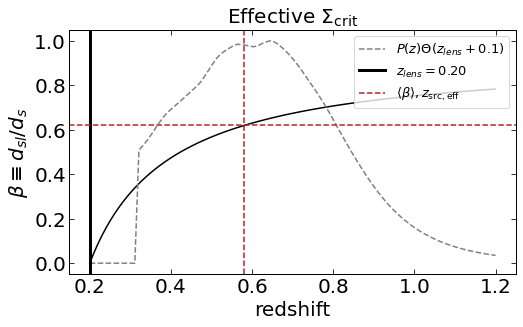

In [17]:
plt.figure(figsize=(8,4.5))
plt.plot(z_source_vec, beta, color='k')
plt.plot(z_source_vec, pz_vec/(np.max(pz_vec)),color='gray',ls='--', label=r'$P(z) \Theta(z_{lens}+0.1)$')

plt.axvline(zl, color='k', lw=3, label=r'$z_{lens} = %.2f$'%(zl))
plt.axhline(beta_mean, color='firebrick', ls='--')
plt.axvline(z_src_eff, color='firebrick', ls='--', label=r'$\left< \beta \right>, z_{\rm src, eff}$')

plt.xlabel('redshift')
plt.ylabel(r'$\beta \equiv d_{sl}/d_{s} $')
plt.legend(fontsize=13, loc=1)
plt.title(r'Effective $\Sigma_{\rm crit}$',fontsize=20)
plt.savefig('mock_beta_evolution.png', dpi=75, facecolor='w', transparent=False)

In [18]:
def compute_z_src_eff(zl, delta_z=0.1, cosmo=cosmo0):
    # for a given zl
    z_source_vec = np.linspace(zl, 1.2, 100)

    # compute the normalized p(z_source)
    heaviside = np.where(z_source_vec>=zl+delta_z*(1+zl), 1, 0)
    pz_vec = heaviside*pz_interp(z_source_vec)
    pz_vec /= np.trapz(pz_vec, x=z_source_vec)

    # compute comving distances
    dl = cosmo.angular_diameter_distance(zl).value

    # compute betas
    ds = cosmo.angular_diameter_distance(z_source_vec).value
    dsl = cosmo.angular_diameter_distance_z1z2(zl, z_source_vec).value
    beta = dsl/ds

    # integrate over betas
    beta_mean = np.trapz(pz_vec*beta, x=z_source_vec)

    # effective redshift source
    z_src_eff = np.interp(beta_mean, beta, z_source_vec)
    
    return z_src_eff, beta_mean


### Dependence of $z_{\rm lens}$

In [19]:
print('Some important effective values')
for zl in [0.2, 0.3, 0.6]:
    zi, bi = compute_z_src_eff(zl, cosmo=cosmo0)
    print('zl, zs, beta: %.2f, %.2f, %.3f'%(zl, zi,bi))

Some important effective values
zl, zs, beta: 0.20, 0.58, 0.620
zl, zs, beta: 0.30, 0.64, 0.489
zl, zs, beta: 0.60, 0.87, 0.259


In [20]:
zarray = np.linspace(0.05, 1.2, 50)
z_eff_sources = np.array([compute_z_src_eff(zl, cosmo=cosmo0)[0] for zl in zarray])
b_eff_sources = np.array([compute_z_src_eff(zl, cosmo=cosmo0)[1] for zl in zarray])

/tmp/ipykernel_99492/3409663859.py:8: RuntimeWarning: invalid value encountered in true_divide
  pz_vec /= np.trapz(pz_vec, x=z_source_vec)


Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

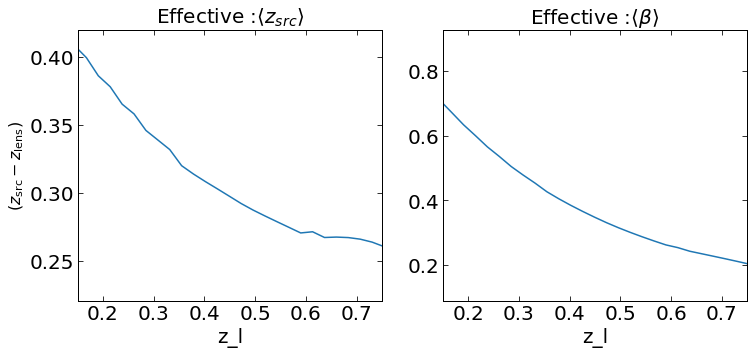

In [21]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(zarray, (z_eff_sources-zarray))
plt.xlim(0.15, 0.75)
plt.ylim(0.22, 0.42)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.ylabel(r'$(z_{\rm src} - z_{\rm lens})$', fontsize=16)
plt.title(r'Effective :$\left<z_{src}\right>$', fontsize=20)

plt.subplot(122)
plt.plot(zarray, b_eff_sources)
plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)
# plt.plot(zarray, beta)

# $\beta$ as a function of Radii

The critical density can be written simply as a normalization factor times the ratio of source-lens distance and source distance. 

$$
\beta \equiv d_{LS}/d_{S}
$$

Then, we can show that when consider the boost factor model that factor can be extended to radii:
$$
\beta(z_L, R) = \beta_{\rm bg}(z_L)\left[1-f_{\rm cls}(R)\right]
$$

The $f_{\rm cls}(R)$ is the fraction of cluster galaxies that has $z_{\rm mcal}>z_{l} +0.1$ multiplied by $\Sigma_{\rm crit}^{-1}$ 

## Modeling Boost-Factor

We model the observed redshift distribution in the line-of-sight of a cluster. Because of the photo-z selection, there are cluster galaxies which leaks into the source selection. We can account the leakage in the selection by modeling the observed photo-z distribution as a function of the radii. 

By assuming a given cluster photo-z distribution we can decompose the observed photo-z distribution as:
$$
P_{\rm observed}(z, R) = f_{\rm cls}(R)*P_{\rm cls}(z) + (1-f_{\rm cls}(R))*P(z) \; .
$$

For instance, for the cluster photo-z distribution we will assume a lorentiaz distribution
$$
P_{\rm cls} (z| z_0, \gamma) = \frac{1}{\pi \gamma \left[1+\left(\frac{z-z_0}{\gamma}\right)^2\right]}
$$
Where $z_0$ and $\gamma$ are the redshift median and the $\sigma_{z, \rm NMAD}$ respectively.

The $f_{\rm cls}(R)$ will use from the boost-factor model.

In [22]:
from setup_bins import lbdbins, zbins

print('lambda bins:', lbdbins)
print('redshift bins:', zbins)

lambda bins: [  5  20  30  45  60 900]
redshift bins: [0.2  0.35 0.5  0.65]


In [23]:
lbdbins = np.array([5, 10, 14, 20, 30, 45, 60, 130])
lbdmean = lbdbins[1:] + np.diff(lbdbins)/2.

### Modeling of $f_{\rm cl}(R)$

In [24]:
path_boost = floc.boost_tamas_y1
fname_base = path_boost+'full-unblind-v2-mcal-zmix_y1clust_l%i_z%i_zpdf_boost_resp.dat'

def lookup_bin(l,z):
    lbin = np.interp(l, lbdbins, np.arange(lbdbins.size)).astype(int)
    zbin = np.interp(z, zbins, np.arange(zbins.size)).astype(int)
    return lbin, zbin
    
def intep_desy1_data(l,z):
    lbin, zbin = lookup_bin(l,z)
    R, B, Sigma = np.genfromtxt(fname_base%(lbin,zbin),unpack=True)
    Offset = np.min(B)
    return R, B, Sigma

def plot_data(l=30,z=0.3,ax=None,**kwargs):
    if ax is None: ax = plt.gca()
    rd, b, b_err = intep_desy1_data(l,z)
    label = r'$\lambda, z = %i, %.2f$'%(l,z)
    ax.errorbar(rd, 1-1/b, yerr=b_err, label=label, **kwargs)
    ax.set_xscale('log')
    ax.set_xlabel(r'$R \; [Mpc]$')

In [25]:
from scipy.optimize import curve_fit

def Boost_Factor_Model(R, Rs, B0):
    """This function is where the boost factor model is calculated. It takes np.arrays for the radius R, Rs and B0."""
    x = R/Rs
    fx = np.zeros(R.size)
    ix,= np.where(x>1)
    fx[ix] = ((np.arctan(np.sqrt((x[ix])**2 -1)))/np.sqrt((x[ix])**2 -1))
    ix,= np.where(x==1)
    fx[ix] = 1
    ix,= np.where(x<1)
    fx[ix] = (np.arctanh(np.sqrt(1 -x[ix]**2))/np.sqrt(1 -x[ix]**2))
    B= 1+B0*((1-fx)/(x**2-1))
    ix,=np.where(np.isnan(B))
    B[ix]=(B0+3)/3
    return B

def plot_fit(l, z, ax=None, **kwargs):
    if ax is None: ax = plt.gca()
    rd, b, b_err = intep_desy1_data(l,z)
    popt, pcov = curve_fit(Boost_Factor_Model, rd, b, p0=[0.3, 1.], sigma=np.sqrt(b_err**2+0.005**2))
    bfit = Boost_Factor_Model(rd, *popt)
    
    ax.errorbar(rd, 1-1/bfit, ls='--', yerr=b_err, **kwargs)
    ax.set_xscale('log')
    ax.set_xlabel(r'$R \; [Mpc]$')
    
    return popt, pcov
    

In [26]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'g', 'b', 'r']

Text(0.5, 1.0, '$\\lambda$ bins')

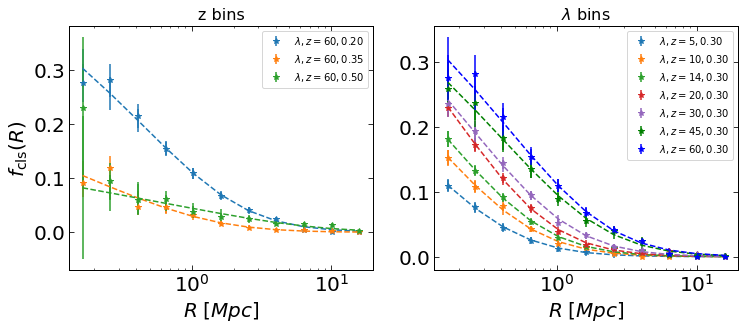

In [27]:
plt.figure(figsize=(12,4.5))

plt.subplot(121)
zmean = zbins[:-1]+0.0025
for zi,ci in zip(zmean,colors[:3]):
    plot_data(l=60, z=zi, color=ci, fmt='*')
    plot_fit(l=60, z=zi, color=ci)
    
plt.legend()
plt.ylabel(r'$f_{\rm cls}(R)$')
plt.title(r'z bins',fontsize=16)

plt.subplot(122)
lbdmean = lbdbins[:-1]
for li, ci in zip(lbdmean, colors):
    plot_data(li, z=0.3, color=ci, fmt='*')
    plot_fit(l=li, z=0.3, color=ci)
plt.legend()
plt.title(r'$\lambda$ bins',fontsize=16)

In [28]:
def fit_data(l,z):
    rd, b, b_err = intep_desy1_data(l,z)
    popt, pcov = curve_fit(Boost_Factor_Model, rd, b, sigma=np.sqrt(b_err**2+0.03**2))
    return popt, pcov

In [29]:
fitparams = dict()
fitparams['lambda'] = lbdbins[:-1]#(lbdmean+np.diff(lbdbins)/2.).astype(float)
# fitparams['lambda'][-1] = 120
fitparams['redshift'] = zbins[:-1]#(zmean+np.diff(zbins)/2.).astype(float)
# fitparams['b0'] = np.zeros((lbdmean.size*zmean.size,2))
# fitparams['rs'] = np.zeros((lbdmean.size*zmean.size,2))

b0, cb0 = [], []
rs, crs = [], []
for i,li in enumerate(lbdmean):
    r1, r2 = [], []
    c1, c2 = [], []
    for j,zi in enumerate(zmean):
        pars, covp = fit_data(li,zi)
        ij = (i*zmean.size)+j
        r1.append(pars[0])
        c1.append(covp[0,0])
        
        r2.append(pars[1])
        c2.append(covp[1,1])
    b0.append(r2)
    cb0.append(c2)
    
    rs.append(r1)
    crs.append(c1)

In [30]:
fitparams['b0'] = np.array(b0)
fitparams['rs'] = np.array(rs)

fitparams['b0_err'] = np.array(cb0)
fitparams['rs_err'] = np.array(crs)

In [31]:
fitparams['b0']

array([[0.15118265, 0.09541065, 0.14909014],
       [0.17348479, 0.05853046, 0.09366364],
       [0.20107862, 0.07296284, 0.087792  ],
       [0.26548733, 0.05870233, 0.05506836],
       [0.20696555, 0.05590278, 0.04740736],
       [0.17685159, 0.04151177, 0.06101111],
       [0.19852435, 0.0637635 , 0.05677087]])

In [32]:
fitparams['b0'][:,-1] = fitparams['b0'][:,-2]

In [33]:
from scipy.interpolate import interp1d, RectBivariateSpline

rs_interp = RectBivariateSpline(fitparams['redshift'], fitparams['lambda'], fitparams['rs'].T, kx=1, ky=1)
b0_interp = RectBivariateSpline(fitparams['redshift'], fitparams['lambda'], fitparams['b0'].T, kx=1, ky=1)


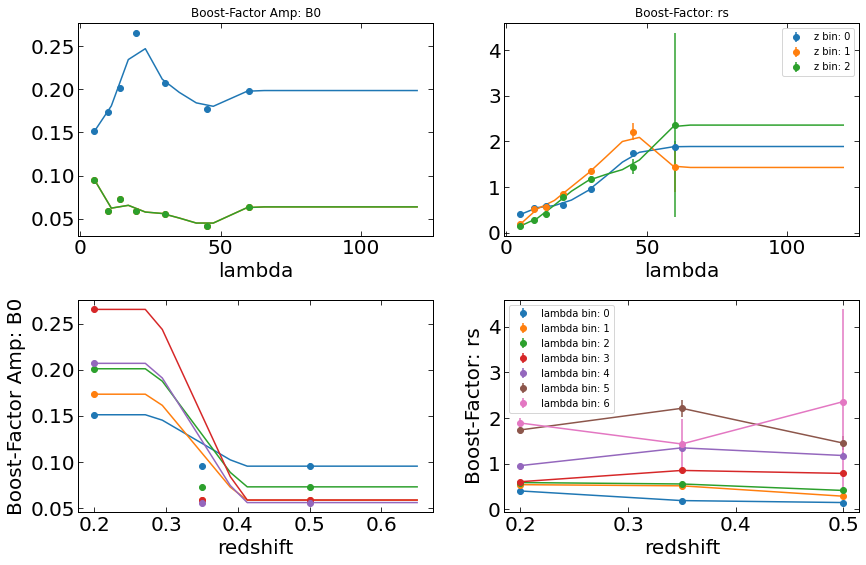

In [34]:
plt.figure(figsize=(14,9))

plt.subplot(2, 2, 1)

for i in range(3):
    zi = fitparams['redshift'][i]
    b0inter = b0_interp(zi, np.linspace(5, 120,20))
    p = plt.plot(np.linspace(5, 120,20), b0inter.flatten())
    plt.errorbar(fitparams['lambda'], fitparams['b0'][:,i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor Amp: B0')

plt.subplot(2,2,2)
for i in range(3):
    rsinter = rs_interp(fitparams['redshift'][i], np.linspace(5, 120,20))
    p = plt.plot(np.linspace(5, 120,20), rsinter.flatten())
    plt.errorbar(fitparams['lambda'], fitparams['rs'][:,i], yerr=fitparams['rs_err'][:,i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())

# plt.plot([30], [0.], color='k', label='Fitted Model')
plt.legend(ncol=1)
plt.xlabel('lambda')
plt.title('Boost-Factor: rs')

plt.subplot(2,2,3)
for i in range(5):
    b0inter = b0_interp(np.linspace(0.1, 0.65, 20), fitparams['lambda'][i])
    p = plt.plot(np.linspace(0.2, 0.65, 20), b0inter.flatten())
    plt.errorbar(fitparams['redshift'], fitparams['b0'][i], yerr=fitparams['b0_err'][i], 
                 fmt='o', label='z bin: %i'%i, color=p[0].get_color())
    
# plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor Amp: B0')

plt.subplot(2,2,4)
for i in range(fitparams['lambda'].size):
    p = plt.plot(fitparams['redshift'], fitparams['rs'][i])
    plt.errorbar(fitparams['redshift'], fitparams['rs'][i], yerr=fitparams['rs_err'][i], 
                 fmt='o', label='lambda bin: %i'%i, color=p[0].get_color())
    
plt.legend(ncol=1)
plt.xlabel('redshift')
plt.ylabel('Boost-Factor: rs')
plt.subplots_adjust(hspace=0.3)

## Interpolate $f_{\rm cl}(R)$

In [35]:
rmin, rmax, Nrbins = 0.05, 15., 100
radii = np.logspace(np.log10(rmin), np.log(rmax), Nrbins) 

In [36]:
def fcl_interp(zval,lval):
    b0i = b0_interp(zval,lval).flatten()
    rsi = rs_interp(zval,lval).flatten()
    
    binterp = Boost_Factor_Model(radii, rsi, b0i)
    return 1- 1./binterp

Text(0.5, 1.0, '$\\lambda$ bins')

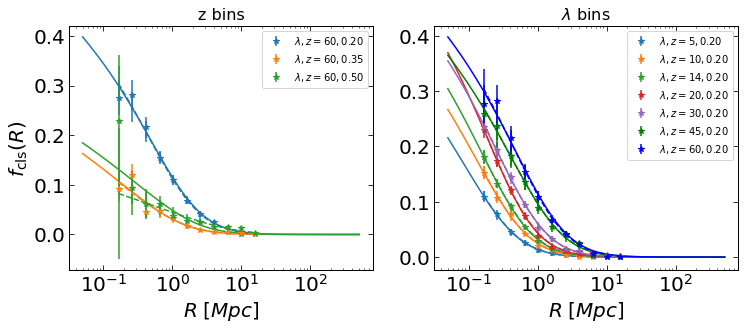

In [37]:
plt.figure(figsize=(12,4.5))

plt.subplot(121)
zmean = zbins[:-1]
for zi,ci in zip(zmean,colors[:3]):
    plt.plot(radii, fcl_interp(zi, 60), color=ci)
    plot_data(l=60, z=zi, color=ci, fmt='*')
    plot_fit(l=60, z=zi, color=ci)
    
plt.legend()
plt.ylabel(r'$f_{\rm cls}(R)$')
plt.title(r'z bins',fontsize=16)

plt.subplot(122)
lbdmean = lbdbins[:-1]
for li, ci in zip(lbdmean, colors):
    plt.plot(radii, fcl_interp(0.2, li), color=ci)
    plot_data(li, z=0.2, color=ci, fmt='*')
    plot_fit(l=li, z=0.2, color=ci)
plt.legend()
plt.title(r'$\lambda$ bins',fontsize=16)

## Create Photo-z Distribution

### Cluster Photo-z: Lorentianz

In [38]:
zvec = np.linspace(0.1, 1.1, 100)

def lorentianz(x, x0, gamma):
    den = np.pi*gamma
    den*= (1+((x-x0)/gamma)**2)
    return 1/den

def gaussian(x, x0, sigma):
    arg = (x-x0)/sigma
    return np.exp(-arg**2)/np.sqrt(2*np.pi*sigma**2)

def compute_pz_cls(zvec, z0, sigma):
    # converts std to mad
    sigma *= (1+z0)*np.sqrt(2/np.pi)
    res = lorentianz(zvec, z0, sigma)
    #res = gaussian(zvec, z0, sigma/np.sqrt(2/np.pi))
    return res

In [39]:
def plot_pz_total(r, lb, zl, zvec, sigmaz=0.03, ax=None):
    if ax is None: ax = plt.gca()
    fcl_vec = fcl_interp(zl,lb)
    fcls = np.interp(r, radii, fcl_vec)
    print(fcls)
    
    heaviside = np.where(zvec>zl+0.1, 1., 0.)
    pz_cls = compute_pz_cls(zvec, zl, sigmaz)
    pz_cls /= np.trapz(heaviside*pz_cls, x=zvec)
    
    pz_bg = pz_interp(zvec)
    pz_bg /= np.trapz(pz_interp(zvec)*heaviside, x=zvec)

    pz_total = (fcls*pz_cls + (1-fcls)*pz_bg)
        
    plt.plot(zvec, heaviside*fcls*pz_cls, color='tab:red', label=r'$P_{\rm cls}(z)$')
    plt.plot(zvec, (1-fcls)*pz_bg,'k--', label=r'$P_{\rm bg}(z)$')
    plt.plot(zvec, heaviside*pz_total,'k-', label=r'$P_{\rm total}(z)$')
    plt.axvline(zl+0.1,color='gray',lw=2,label=r'$z_{cls}+0.1$')
    plt.xlabel('redshift')

0.28237139515517884
0.1437048788023962
0.08533986567999659


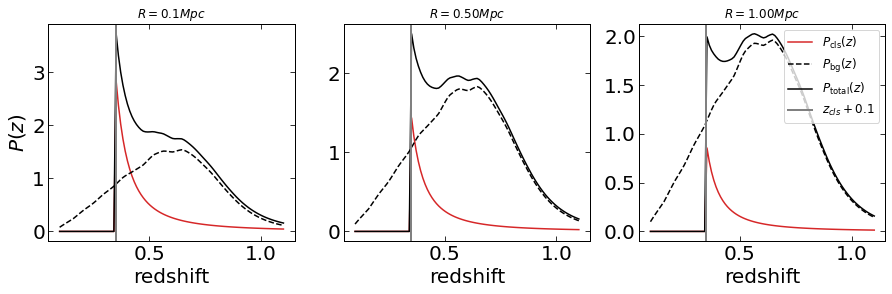

In [40]:
plt.figure(figsize=(15,4.))
l, z = 80, 0.25

plt.subplot(1, 3, 1)
plot_pz_total(0.1, l, z, zvec)
plt.ylabel(r'$P(z)$')
plt.title(r'$R=0.1 Mpc$')

plt.subplot(1, 3, 2)
plot_pz_total(0.5, l, z, zvec)
plt.title(r'$R=0.50 Mpc$')

plt.subplot(1, 3, 3)
plot_pz_total(1.0, l, z, zvec)
plt.title(r'$R=1.00 Mpc$')
plt.legend(fontsize=12, loc=1)

## $\beta$ as a function of Radii
Let's compute the $\beta(z_L, R)$:
$$
\beta(z_L, R) = fc_{\rm cls}(R)\beta_{\rm cls}(z_L)+ (1-fc_{\rm cls})\beta_{\rm bg}(z_L)
$$

In [41]:
def compute_z_src_eff_radii(zl, r, lb, delta_z=0.1, sigmaz=0.03, cosmo=cosmo0):
    # for a given zl
    z_source_vec = np.linspace(zl, 1.2, 100)

    # compute the normalized p(z_source)
    heaviside = np.where(z_source_vec>=zl+delta_z, 1, 0)
    
    # photo-z distribution pdf(z)
    pz_cls = heaviside*compute_pz_cls(z_source_vec, zl, sigmaz)
    pz_bg = heaviside*pz_interp(z_source_vec)
    
    # normalize
    pz_cls /= np.trapz(heaviside*pz_cls, x=z_source_vec)
    pz_bg /= np.trapz(heaviside*pz_bg, x=z_source_vec)
    
    # fcls
    fcl_vec = fcl_interp(zl, lb)
    fcls = np.interp(r, radii, fcl_vec)
    #print('%.2f, %2f'%(r, fcls))
    
    # compute comving distances
    dl = cosmo.angular_diameter_distance(zl).value

    # compute betas
    ds = cosmo.angular_diameter_distance(z_source_vec).value
    dsl = cosmo.angular_diameter_distance_z1z2(zl, z_source_vec).value
    beta = dsl/ds

    # integrate over betas
    beta_cls = np.trapz(pz_cls*beta, x=z_source_vec)
    beta_bg = np.trapz(pz_bg*beta, x=z_source_vec)
    
    # beta effective
    beta_mean = beta_bg*(1-fcls)
    #print('%.2f, %2f'%(beta_cls, beta_bg))
    # effective redshift source
    z_src_eff = np.interp(beta_mean, beta, z_source_vec)
    
    return fcls, beta_mean

In [42]:
dz=0.05
zarray = np.arange(0.1, 0.65+dz, dz)
rarray = np.logspace(-2, np.log10(15), 30)

def get_beta_2d(lb):
    beta_2d = np.zeros((zarray.size, rarray.size))
    zsrc_2d = np.zeros((zarray.size, rarray.size))
    for i,zl in enumerate(zarray):
        for j,ri in enumerate(rarray):
            zeff, beff = compute_z_src_eff_radii(zl, ri, lb, delta_z=0.1, cosmo=cosmo0)
            beta_2d[i,j] = beff
            zsrc_2d[i,j] = zeff
    return zsrc_2d, beta_2d

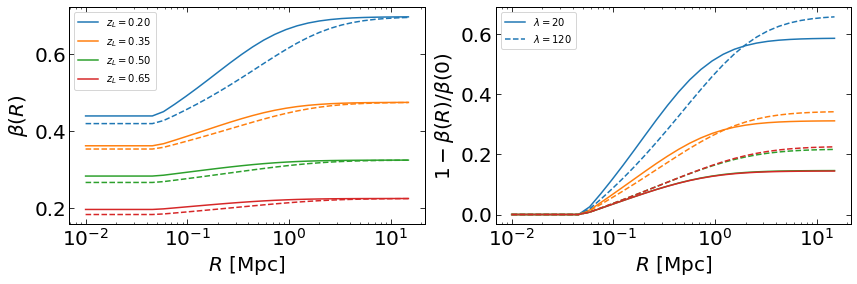

In [43]:
plt.figure(figsize=(14,4.))
li = lbdbins[3]
zsrc_2d, beta_2d = get_beta_2d(li)
plt.subplot(1,2,1)
plt.xscale('log')
for zi,ci in zip([0.2, 0.35, 0.5, 0.65],colors):
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    plt.plot(rarray, (beta_2d[ix]), label=r'$z_L =%.2f$'%(zi))
    #plt.plot(rarray, zsrc_2d[i], label=r'$z_L =%.2f$'%(zarray[i]))
    
plt.legend()
plt.ylabel(r'$\beta(R)$')
plt.xlabel(r'$R$ [Mpc]')

zsrc_2d, beta_2d = get_beta_2d(120)
plt.subplot(1,2,1)
plt.xscale('log')
for zi,ci in zip([0.2, 0.35, 0.5, 0.65],colors):
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    plt.plot(rarray, (beta_2d[ix]), color=ci, ls='--')

li = lbdbins[3]
zsrc_2d, beta_2d = get_beta_2d(li)
plt.subplot(1,2,2)
plt.xscale('log')
for zi,ci in zip([0.2, 0.35, 0.5, 0.65],colors):
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    label = None
    if ci == 'tab:blue': label = r'$\lambda = %i$'%(li)
    plt.plot(rarray, (beta_2d[ix]-beta_2d[ix][0])/beta_2d[ix][0], label=label)
    
plt.ylabel(r'$1- \beta(R)/\beta(0)$')
plt.xlabel(r'$R$ [Mpc]')

zsrc_2d, beta_2d = get_beta_2d(120)
plt.subplot(1,2,2)
plt.xscale('log')
for zi,ci in zip([0.2, 0.35, 0.5, 0.65],colors):
    ix = np.interp(zi, zarray, np.arange(zarray.size)).astype(int)
    label = None
    if ci == 'tab:blue': label = r'$\lambda = %i$'%(120)
    plt.plot(rarray, (beta_2d[ix]-beta_2d[ix][0])/beta_2d[ix][0], color=ci, ls='--', label=label)
plt.legend()

## Write Beta Vector 

In [44]:
fname = floc.mock_boost_factor_2d
np.savez(fname, betaEff=beta_2d, zEff=zsrc_2d, zlens=zarray, Radii=rarray)
print('Save beta(R,zl) table: %s'%(fname))

Save beta(R,zl) table: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/beta_table_zl_radii_y1_like.npz


In [45]:
# just take the last bin
beta_1d = np.repeat(beta_2d[:, -1], rarray.size).reshape(zarray.size, rarray.size)
zsrc_1d = np.repeat(zsrc_2d[:, -1], rarray.size).reshape(zarray.size, rarray.size)


In [46]:
fname = floc.mock_boost_factor_1d
np.savez(fname, betaEff=beta_1d, zEff=zsrc_1d, zlens=zarray, Radii=rarray)
print('Save beta(zl) table: %s'%(fname))

Save beta(zl) table: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/beta_table_zl_y1_like.npz


## How Does this depends on cosmology?

In [44]:
cosmos = []
omega_vec = [0.10, 0.15, 0.2, 0.25, 0.3, 0.35]
for omi in omega_vec:
    cosmos.append(FlatLambdaCDM(H0=70, Om0=omi, Tcmb0=2.725))

# for hi in np.linspace(65, 75, 4):
#     cosmos.append(FlatLambdaCDM(H0=hi, Om0=0.3, Tcmb0=2.725))

In [45]:
z_eff_sources_cosmo, b_eff_sources_cosmo =[], []
for cosmoi in cosmos:
    z_eff_sources_cosmo.append(np.array([compute_z_src_eff(zl, cosmo=cosmoi)[0] for zl in zarray]))
    b_eff_sources_cosmo.append(np.array([compute_z_src_eff(zl, cosmo=cosmoi)[1] for zl in zarray]))

Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

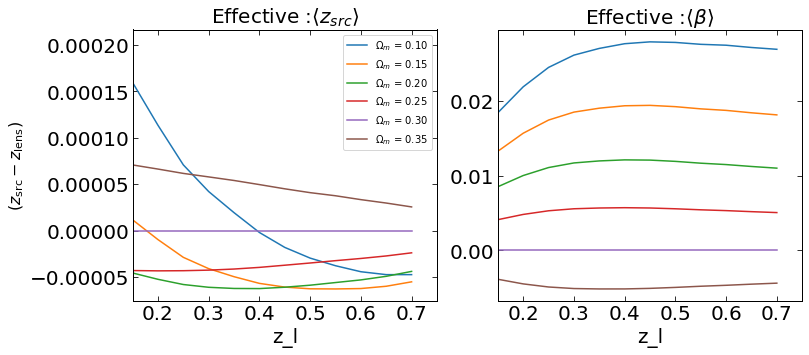

In [46]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
for i, z_eff_sources in enumerate(z_eff_sources_cosmo):
    plt.plot(zarray, (z_eff_sources-z_eff_sources_cosmo[4]), 
             label=r'$\Omega_m$ = %.2f'%omega_vec[i])
    
plt.xlim(0.15, 0.75)
# plt.ylim(0.22, 0.42)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.legend()
plt.xlabel('z_l')
plt.ylabel(r'$(z_{\rm src} - z_{\rm lens})$', fontsize=16)
plt.title(r'Effective :$\left<z_{src}\right>$', fontsize=20)

plt.subplot(122)
for b_eff_sources in b_eff_sources_cosmo:
    plt.plot(zarray, b_eff_sources-b_eff_sources_cosmo[4])

plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)
# plt.plot(zarray, beta)

### With Scaling Factor Correction

In [47]:
def scaleShiftCosmo(znew, cosmo):
    # redshift
    z_dc = np.linspace(0., 1.4, 50)
    
    # h0
    h0 = cosmo.H0/100.
    dc = cosmo.comoving_distance(z_dc).value
    
    # fiducical cosmology
    h0_fid = cosmo0.H0/100.
    dc_fid = cosmo0.comoving_distance(z_dc).value
    
    # scale shift
    scale_shift_vec = dc/dc_fid
    
    # interpolate for the new redshift
    scale_shift = np.interp(znew, z_dc, scale_shift_vec)
    return scale_shift

def beta_cosmo_corr(zS, zL, beta_fid, cosmo=cosmo0):
    scale_src = scaleShiftCosmo(zS, cosmo)
    scale_lens= scaleShiftCosmo(zL, cosmo)
    scale_ratio = scale_src/scale_lens
    print(scale_ratio)
    return 1 - scale_ratio*(1-beta_fid)

In [48]:
b_eff_cosmo_corr = [beta_cosmo_corr(zi, zarray, bi, cosmo) for zi, bi, cosmo 
                    in zip(z_eff_sources_cosmo, b_eff_sources_cosmo, cosmos) ]

[1.06962893 1.06516669 1.06098444 1.05776896 1.05392023 1.05009022
 1.04734909 1.04478013 1.04230064 1.04008818 1.03860007 1.03707011
 1.0358821 ]
[1.04964903 1.04625646 1.04307958 1.04058833 1.03769082 1.03483273
 1.0327351  1.0307794  1.0289043  1.02723011 1.02605182 1.02486801
 1.0239212 ]
[1.0315803  1.02930282 1.02717392 1.02548237 1.02355931 1.02167731
 1.02027279 1.01897061 1.01773006 1.01662391 1.01582462 1.01503483
 1.01439372]
[1.01511068 1.01396939 1.012905   1.01205162 1.01109946 1.01017416
 1.00947555 1.00883135 1.00822124 1.00767836 1.00727942 1.00689023
 1.00657166]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.98605882 0.98719459 0.98824813 0.9891018  0.9900268  0.99091492
 0.99159535 0.99221664 0.99279914 0.99331504 0.99370171 0.99407197
 0.99437755]


/tmp/ipykernel_78271/3351393123.py:14: RuntimeWarning: invalid value encountered in true_divide
  scale_shift_vec = dc/dc_fid


Text(0.5, 1.0, 'Effective :$\\left<\\beta\\right>$')

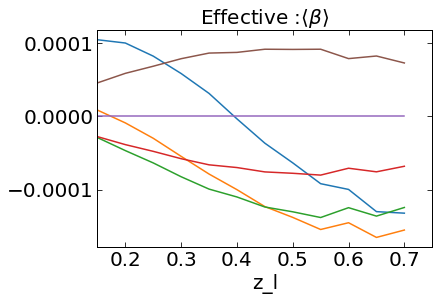

In [49]:
for b_eff_sources in b_eff_cosmo_corr:
    plt.plot(zarray, (b_eff_sources-b_eff_sources_cosmo[4])/b_eff_sources_cosmo[4])

plt.xlim(0.15, 0.75)
_ = plt.xticks(np.linspace(0.2, 0.7, 6))
plt.xlabel('z_l')
plt.title(r'Effective :$\left<\beta\right>$', fontsize=20)


After the cosmological correction the difference is in the order of 0.01 %. 

## Checking Mass-Concentration Relation

https://arxiv.org/pdf/1812.05995.pdf (equation 68) Dufy et al. 2008

In [50]:
Mp = 2e12*0.7 # Msun
def conc(M,z):
    c = 7.85*(M/Mp)**(-0.081)
    c*= (1+z)**(-0.71)
    return c

In [51]:
mass = np.logspace(13.5, 15.1, 21)
zvec = np.arange(0.2, 0.70+0.1, 0.1)

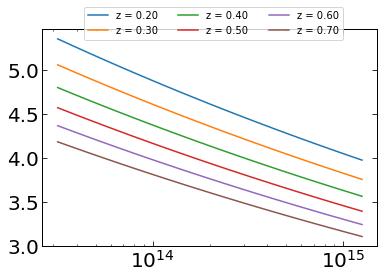

In [52]:
plt.xscale('log')
c033 = conc(mass, 0.4)
for zi in zvec:
    plt.plot(mass, conc(mass, zi), label='z = %.2f'%zi)
    
plt.legend(loc=(0.125,0.95), ncol=3, frameon=True)

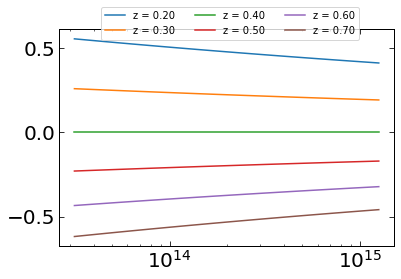

In [53]:
plt.xscale('log')
c033 = conc(mass, 0.4)
for zi in zvec:
    plt.plot(mass, conc(mass, zi)-c033, label='z = %.2f'%zi)
    
plt.legend(loc=(0.125,0.95), ncol=3, frameon=True)

In [54]:
cvec = np.linspace(3, 5, 3)
r = np.logspace(-1, 1, 10)

In [55]:
np.repeat(r, cvec.size)

array([ 0.1       ,  0.1       ,  0.1       ,  0.16681005,  0.16681005,
        0.16681005,  0.27825594,  0.27825594,  0.27825594,  0.46415888,
        0.46415888,  0.46415888,  0.77426368,  0.77426368,  0.77426368,
        1.29154967,  1.29154967,  1.29154967,  2.15443469,  2.15443469,
        2.15443469,  3.59381366,  3.59381366,  3.59381366,  5.9948425 ,
        5.9948425 ,  5.9948425 , 10.        , 10.        , 10.        ])

In [56]:
lbdbins =  np.array([20, 30, 45, 60, 300])
lbdmeans = 0.5*(lbdbins[1:]+lbdbins[:-1])
lbdmeans

array([ 25. ,  37.5,  52.5, 180. ])

In [57]:
np.repeat(lbdmeans, 3)

array([ 25. ,  25. ,  25. ,  37.5,  37.5,  37.5,  52.5,  52.5,  52.5,
       180. , 180. , 180. ])

In [58]:
def area_intersection(r_mis, r_lambda):
    # separation normalized by r_lambda
    x = r_mis/r_lambda
    
    # intersection area of two circles
    a_in = 2*r_lambda**2

    a_in *= np.arccos(x/2.) - (x/2.)*np.sqrt(1-(x/2.)**2)
    return a_in

In [59]:
def area_intersection(r_mis, r_lambda):
    # separation normalized by r_lambda
    x = r_mis/r_lambda
    
    # intersection area of two circles
    a_in = 2*r_lambda**2

    a_in *= np.arccos(x/2.) - (x/2)*np.sqrt(1-(x/2.)**2)
    return a_in

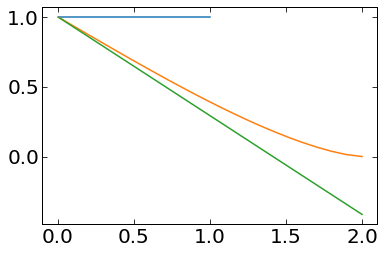

In [60]:
r_mis_vec = np.logspace(-2, np.log10(2), 100)
plt.plot([0,1], [1., 1.])
plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
plt.plot(r_mis_vec, 1-r_mis_vec/np.sqrt(2))

In [61]:
def gaussian(x,x0,sigma):
    return np.exp(-((x-x0)/sigma)**2)/np.sqrt(2*np.pi*sigma)

def area_model(r_mis, r_lambda):
    x = r_mis/r_lambda
    xx, xx2 = np.meshgrid(x, x)
    
    alpha  = 1.66
    a = 0.26
    b = 1.43
    y_mean = np.exp(-xx**2/alpha**2)
    sigma = a*np.arctan(b*xx)
    
    return gaussian(x, y_mean, sigma)

In [62]:
r_mis_vec = np.logspace(-2, np.log10(2), 100)
x = r_mis_vec/1.
xx, xx2 = np.meshgrid(x, x)

alpha  = 1.66
a = 0.26
b = 1.43
y_mean = np.exp(-x**2/alpha**2)
sigma = a*np.arctan(b*x)

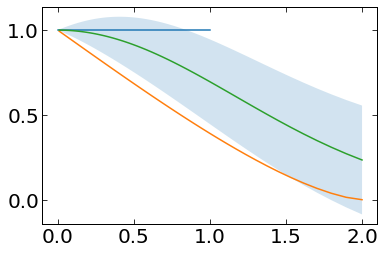

In [63]:
plt.plot([0,1], [1., 1.])
plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
plt.fill_between(x, y_mean -sigma, y_mean +sigma, alpha=0.2)
plt.plot(x, y_mean)

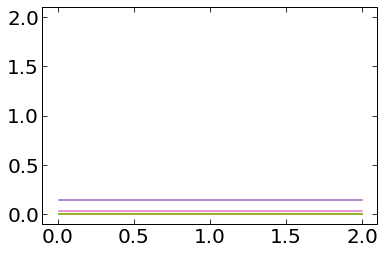

In [64]:
r_mis_vec = np.logspace(-2, np.log10(2), 10)
# plt.plot([0,1], [1., 1.])
# plt.plot(r_mis_vec, area_intersection(r_mis_vec, 1.)/np.pi)
# plt.plot(r_mis_vec, 1-r_mis_vec/np.sqrt(2))
y_vec = area_model(r_mis_vec, 1.).T
for xi,yi in zip(r_mis_vec, y_vec):
    plt.plot(r_mis_vec, yi, xi)

In [756]:
10**5/1000

100.0